# Ackley Function

The Ackley function is a commonly used benchmark function in the field of optimization, particularly in evolutionary and genetic algorithms. It is a non-linear, multimodal function that presents a significant challenge for optimization algorithms due to its large search space and many local optima. The function is defined over a multi-dimensional domain, typically real numbers, and it is characterized by a nearly flat outer region, and a large hole at the center. The function is used to assess the performance of optimization algorithms - if an algorithm can find the global minimum of the Ackley function, it demonstrates that the algorithm is adept at escaping local optima. The global minimum for the Ackley function is usually at the origin (0,0) where the function value is also 0, for the common case of two dimensions. However, these values would extend to more zeros as the dimensions increase. The function poses a risk for optimization algorithms, particularly hill climbing algorithms, to be trapped in one of its many local minima. $a = 20$, $b = 0.2$ and $c = 2π$.

The mathematical form is given by:
$$f(\mathbf{x}) = -a \exp \left(-b \sqrt{\frac{1}{d} \sum_{i=1}^d x_i^2} \right) - \exp \left(\frac{1}{d} \sum_{i=1}^d \cos (c x_i) \right) + a + \exp(1)$$

## Input Domain
The function is usually evaluated at $x_i \in [-32.768, 32.768]$, for all $i = 1, \ldots, d$, although it may also be restricted to a small domain.

## Global Minima
The global minimum of the function is at $f(\textbf{x}^*) = 0$ at $x^* = (0, \ldots, 0)$.

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from cyipopt import minimize_ipopt

from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

In [2]:
def objective(x, y):
    a = 20.0
    b = 0.2
    c = 2 * np.pi
    return (
        -a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2)))
        - np.exp(0.5 * (np.cos(c * x) + np.cos(c * y)))
        + a
        + np.e
    )

In [3]:
# Make sure the objecive function is correct
objective(0.0, 0.0)

4.440892098500626e-16

Text(0.5, 0.92, 'Ackley Function Surface Plot')

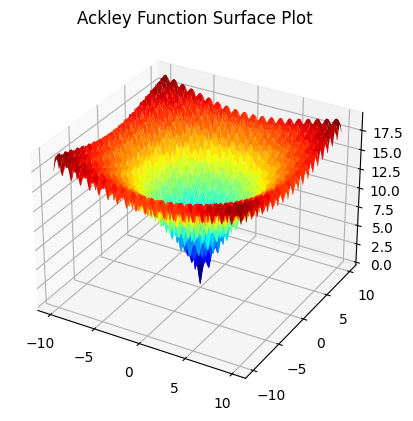

In [4]:
# Plot the Ackley Function in 3D
r_min, r_max = -10, 10
x_axis = y_axis = np.arange(r_min, r_max, 0.05)
x, y = np.meshgrid(x_axis, y_axis)
f = objective(x, y)

figure = plt.figure()
axis = figure.add_subplot(111, projection="3d")
axis.plot_surface(x, y, f, cmap="jet", shade="false")

# Set the title
axis.set_title("Ackley Function Surface Plot")

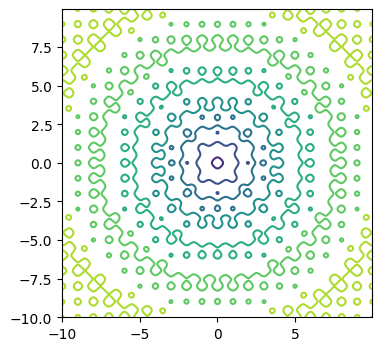

In [5]:
# Let's also view the contours
figure = plt.figure(figsize=(4, 4))
plt.contour(x, y, f)

# `PyGranso` Solution

The initial objective we've set for ourselves is to tackle the Ackley optimization problem using our proprietary software, PyGranso. The Ackley problem, known for its complexity and vast search space, offers a meaningful challenge to evaluate the efficiency and efficacy of our optimization algorithms. To begin with, we will examine the solution in a two-dimensional space, a common starting point for assessing the Ackley function. Once we have a satisfactory solution in two dimensions, we'll incrementally scale upward, expanding the problem's complexity by increasing the number of dimensions. This progressive approach will help us to thoroughly evaluate the robustness of PyGranso's solutions in higher-dimensional optimization scenarios.

## Function Set-Up

Encode teh optimization variables, and the objective and constraint functions.

In [6]:
# Setup the device
device = torch.device("cpu")

# Input variables
var_in = {"x1": [1], "x2": [1]}


def objective(x, y):
    a = 20.0
    b = 0.2
    c = 2 * np.pi
    return (
        -a * torch.exp(-b * torch.sqrt(0.5 * (x**2 + y**2)))
        - torch.exp(0.5 * (torch.cos(c * x) + torch.cos(c * y)))
        + a
        + torch.e
    )


# Create the combined function
def comb_fn(X_struct):
    x1 = X_struct.x1
    x2 = X_struct.x2

    # Objective function
    f = objective(x1, x2)

    # Inequality constraint
    ci = None

    # equality constraint
    ce = None

    return f, ci, ce

## Main Algorithm

In [7]:
# Try many different random starts

for trial in range(10):
    torch.manual_seed(trial)
    # Setup a pygransoStruct for the algorithm
    # options
    opts = pygransoStruct()

    # With random variables between -32, 32
    x0 = torch.rand(size=(2, 1), device=device, dtype=torch.double) * 64 - 32

    opts.x0 = x0
    opts.torch_device = device

    # Run the main algorithm
    start = time.time()
    soln = pygranso(var_spec=var_in, combined_fn=comb_fn, user_opts=opts)
    end = time.time()

    print(f"Trial {trial + 1}")
    print(f"Starting point for problem = {x0}")
    print("\n")
    print("Total Wall Time: {}s".format(end - start))
    print(soln.final.x, soln.final.f)
    print("\n")



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

# First Observations 👀

Our preliminary findings indicate that the Ackley function poses a considerable challenge for our proprietary software, PyGranso, especially when it comes to finding an easy solution from arbitrary starting points. Given the complex nature of the Ackley function with its multitude of local optima, it's not entirely surprising that PyGranso struggles to find a quick and efficient solution. However, this realization provides an impetus for further exploration and fine-tuning of our methods. In the forthcoming stages of our research, we intend to investigate more deeply and also introduce alternative optimization solvers into our toolkit. One promising candidate is IPOPT, a powerful open-source optimizer that has demonstrated efficacy in solving a wide range of complex optimization problems. By utilizing a diverse array of solvers, we aim to enhance our ability to handle complex optimization challenges such as the Ackley function.

In [8]:
def objective(x):
    a = 20.0
    b = 0.2
    c = 2 * np.pi
    return (
        -a * np.exp(-b * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2)))
        - np.exp(0.5 * (np.cos(c * x[0]) + np.cos(c * x[1])))
        + a
        + np.e
    )


for trial in range(10):
    np.random.seed(trial)
    # Initial guess (starting point for IPOPT)
    x0 = np.random.rand(2) * 64 - 32

    # Call IPOPT
    res = minimize_ipopt(objective, x0)

    # Print the optimized parameters
    print(f"Trial {trial + 1}")
    print("Optimized Parameters:", res.x)

    # Print the minimum of the function
    print("Minimum of Ackley function:", objective(res.x))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Trial 1
Optimized Parameters: [ 2.99853974 13.99318349]
Minimum of Ackley function: 17.35841471446555
Trial 2
Optimized Parameters: [-2.99080073  5.98157064]
Minimum of Ackley function: 12.243742397870664
Trial 3
Optimized Parameters: [ -0.99989369 -21.99766088]
Minimum of Ackley function: 19.111823217444602
Trial 4
Optimized Parameters: [ 0.99899639 10.98895154]
Minimum of Ackley function: 15.802598259176918
Trial 5
Optimized Parameters: [29.99926198  2.99992619]
Minimum of Ackley function: 19.71861076872308
Trial 6
Optimized Parameters: [-20.99974342  26.99967009]
Minimum of Ackley function: 19.841435340

In [21]:
from scipy.optimize import dual_annealing
import numpy as np


def ackley(x):
    arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
    arg2 = 0.5 * (np.cos(2.0 * np.pi * x[0]) + np.cos(2.0 * np.pi * x[1]))
    result = -20.0 * np.exp(arg1) - np.exp(arg2) + 20.0 + np.e
    intermediate_values.append((x, result))  # store intermediate values
    return result


# Define the bounds of the solution space
lw = [-5.0, -5.0]
up = [5.0, 5.0]

# list to store intermediate values
intermediate_values = []

# use dual_annealing to find the minimum
ret = dual_annealing(ackley, bounds=list(zip(lw, up)), maxiter=1000)

print("global minimum: x = [%.4f, %.4f], f(x0) = %.4f" % (ret.x[0], ret.x[1], ret.fun))

# # print intermediate values
# for i, val in enumerate(intermediate_values):
#     print(f"Step {i}: x = [{val[0][0]:.4f}, {val[0][1]:.4f}], f(x) = {val[1]:.4f}")

global minimum: x = [-0.0000, -0.0000], f(x0) = 0.0000


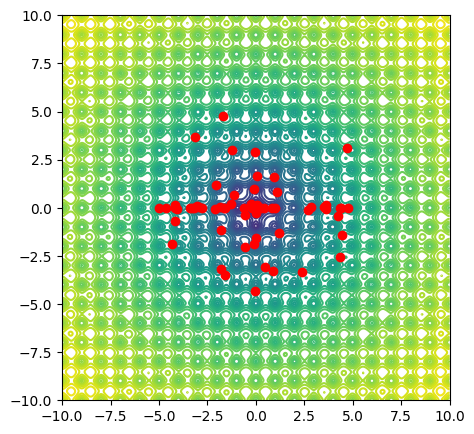

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow


def ackley(x, y):
    arg1 = -0.2 * np.sqrt(0.5 * (x**2 + y**2))
    arg2 = 0.5 * (np.cos(2.0 * np.pi * x) + np.cos(2.0 * np.pi * y))
    return -20.0 * np.exp(arg1) - np.exp(arg2) + 20.0 + np.e


x = np.linspace(-10, 10, 400)
y = np.linspace(-10, 10, 400)
X, Y = np.meshgrid(x, y)
Z = ackley(X, Y)

fig, ax = plt.subplots(figsize=(5, 5))

# plot contour
contour = ax.contour(X, Y, Z, levels=50)

# # Random points for the illustration purpose
# points = np.random.uniform(-5, 5, size=(10, 2))
points = np.array([data for data, _ in intermediate_values][::50])

# plot points and arrows
for i in range(len(points) - 1):
    ax.plot(*points[i], 'ro')

# don't forget the last point
ax.plot(*points[-1], 'ro')

plt.show()